In [1]:
0.6552/0.1439

4.55316191799861

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

import pickle as pk
from PIL import Image
import random

PyTorch Version:  1.0.0
Torchvision Version:  0.2.1


In [2]:
# Detect if we have a GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:',device)

batch_size = 32

device: cuda


In [3]:
from torch.utils.data import Dataset, DataLoader
def dataLoader():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # mean = [0.485, 0.456, 0.406]  std = [0.229, 0.224, 0.225]
    test_augs = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])
    Gallery_dataset = datasets.ImageFolder(root='../数据集/UCMerced_LandUse/data/test', transform=test_augs)
#     Gallery_dataset = datasets.ImageFolder(root='../数据集/Google dataset of SIRI-WHU_earth_im_tiff/12class_tif', transform=test_augs)
    return Gallery_dataset
Gallery_dataset = dataLoader()
Gallery_loader = DataLoader(Gallery_dataset,
                           batch_size = 32, shuffle=False)

## 旋转tensor （没有使用）

In [4]:
# from torchvision.transforms import functional as F
# from torch.nn import functional as F
# import math

# angle = -90*math.pi/180
# theta = torch.tensor([
#     [math.cos(angle),math.sin(-angle),0],
#     [math.sin(angle),math.cos(angle) ,0]
# ], dtype=torch.float)
# grid = F.affine_grid(theta.unsqueeze(0), Gallery_dataset[0][0].unsqueeze(0).size())
# output = F.grid_sample(Gallery_dataset[0][0].unsqueeze(0), grid)
# new_img_torch = output[0]
# # plt.imshow(Gallery_dataset[0][0].numpy().transpose(1,2,0))
# # plt.show()

# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# def tensor2image(data):
#     # 因为做了归一化，要返回标准tensor
#     for i in range(len(data)): # (x-m)/s = y   x = 
#         data[i] = data[i] * std[i] + mean[i]
#     img = transforms.ToPILImage()(data).convert('RGB')
#     plt.imshow(img)
# tensor2image(new_img_torch)

# def rotateImgTensor(input, angle):
#     angle = -angle*math.pi/180
#     theta = torch.tensor([
#         [math.cos(angle),math.sin(-angle),0],
#         [math.sin(angle),math.cos(angle) ,0]
#     ], dtype=torch.float)
#     grid = F.affine_grid(theta.unsqueeze(0), input.unsqueeze(0).size())
#     output = F.grid_sample(input.unsqueeze(0), grid)
#     return output[0]

## 使用之前最强的ResNet34+RMAC

In [5]:
from graduation_pytorch.pooling import RMAC 

## 加载模型：resnet34_whurisi_remote_finetune_
pretrained_net = models.resnet34(pretrained=True)
# pretrained_net = models.resnet34(pretrained=False)
pretrained_net.fc = nn.Linear(512, 21)

pretrained_net.avgpool = RMAC()
pretrained_net.fc = nn.Sequential()
PATH = "./my_model/rmac_L=2_UcRemote_resnet34_fine-tune.pt"  # 默认使用平均池化

pretrained_net.load_state_dict(torch.load(PATH))

In [6]:
pretrained_net = pretrained_net.to(device)
pretrained_net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [7]:
# save to loacl file
# save_path = './features/maxPooling_UcRemote21-train-resnet'
save_path = './features/rmac_L=2_UcRemote21-train-resnet'

def save_data(file, data):
    f = open(file, 'wb+')
    pk.dump(data, f, 0)
    f.close()


def extract_features(model, loader):
    since = time.time()
    features = torch.FloatTensor()
         
    model.eval()

    # Iterate over data.
    for inputs, labels in loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        ff = outputs.data.cpu()
        # norm feature
        fnorm = torch.norm(ff, p=2, dim=1, keepdim=True)
        ff = ff.div(fnorm.expand_as(ff))
        features = torch.cat((features, ff), 0)

    time_elapsed = time.time() - since
    print('Feature extraction complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return features

if os.path.exists(save_path):
    fo = open(save_path, 'rb')
    features = pk.load(fo, encoding='bytes')
    fo.close()
    print("Load features.")
else:
    features = extract_features(pretrained_net, Gallery_loader)
    save_data(save_path, features)
    print("Save features to %s" % (save_path))

Load features.


In [8]:
features[0].shape

torch.Size([512])

## PCA降维 512=>32, 64, 128

In [9]:
import numpy as np
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components=28) #保留0.95的信息
pca.fit(features)
new_features = pca.transform(features)

In [11]:
new_features.shape

(420, 28)

In [12]:
sum(pca.explained_variance_ratio_)

0.7368841078627468

## 局部敏感哈希

In [13]:
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections
import numpy
from nearpy.filters import NearestFilter

In [348]:
# Dimension of our vector space
dimension = 28

# Create a random binary hash with 10 bits
bits = 8
rbp = RandomBinaryProjections('rbp', bits)
rbp1 = RandomBinaryProjections('rbp', bits)
rbp2 = RandomBinaryProjections('rbp', bits)
rbp3 = RandomBinaryProjections('rbp', bits)
rbp4 = RandomBinaryProjections('rbp', bits)
# , rbp1, rbp2
# Create engine with pipeline configuration
engine = Engine(dimension, lshashes=[rbp, rbp1, rbp2, rbp3, rbp4], vector_filters=[NearestFilter(21)])
# 计算目标图片与数据库中每张图像的余弦相似度
# def ann_nearpy(query, features): 
#     for i in range(len(features)):
#         engine.store_vector(features[i], i)
#     return engine.neighbours(query)

In [349]:
for i in range(len(new_features)):
    engine.store_vector(new_features[i], i)

In [350]:
# 提取目标图像的特征  修
def query_feature(input):
    x = input

    x = x.unsqueeze(dim=0)
    x.requires_grad = False

    x.to(device)
    pretrained_net.to('cpu')
    pretrained_net.eval()
    
    pre = pretrained_net(x)
    pre = pre.data.cpu()
    # norm feature
    prenorm = torch.norm(pre, p=2, dim=1, keepdim=True)
    pre = pre.div(prenorm.expand_as(pre))
    return pre

In [351]:
k = 44
query = query_feature(Gallery_dataset[k][0])

In [352]:
query = pca.transform(query) # 对单个512=>32

In [353]:
query = query.reshape(28)

In [354]:
query.shape

(28,)

In [355]:
near_res = engine.neighbours(query)

In [356]:
len(near_res)

21

In [357]:
near_res[0][1]//20

2

In [358]:
# mAP... and  准确率 k = 5 10 20  针对nearpy更改函数
def compute_AP_and_P(list, label):
    P_three = []
    true_size = 0.0
    AP = 0.0
    num = 1
    for i in range(21):
#         print(list[i][1]//20)
        if i == 0:
            continue
        if i < len(list) and list[i][1]//20 == label:
            true_size += 1.
            AP += true_size / (i)
#             num = num + 1
        if i == 5:
            P_three.append(true_size/(i))
        if i == 10:
            P_three.append(true_size/(i))
        if i == 20:
            P_three.append(true_size/(i))
    if true_size == 0.0:
        return 0, [0,0,0]
    return AP/true_size, P_three

In [359]:
len(near_res)

21

In [360]:
compute_AP_and_P(near_res, Gallery_dataset[k][1])

(1.0, [1.0, 1.0, 0.5])

## 计算所有的P@K， 不算mAP（mAP得计算所有

In [361]:
import time
sum_AP = 0.0
P_three_sum = [0,0,0]
consume_time = 0

for k in range(len(Gallery_dataset)): # 对所有图片进行搜索 420  21*20
    print(k)
    query = query_feature(Gallery_dataset[k][0])
    query = pca.transform(query) # 对单个512=>32
    query = query.reshape(28)
    time_start = time.time()
    near_res = engine.neighbours(query)
    time_end = time.time()
    consume_time += time_end-time_start
    AP, P_three = compute_AP_and_P(near_res, Gallery_dataset[k][1])
    if k % 50 == 0:
        print('k: ', k ,'label: ', Gallery_dataset[k][1], 'AP: ', AP)
    sum_AP += AP
    for i in range(3):
        P_three_sum[i] += P_three[i]
mAP = sum_AP / len(Gallery_dataset)
P_three_mean = [0,0,0]
for i in range(3):
    P_three_mean[i] = P_three_sum[i]/len(Gallery_dataset)

0
k:  0 label:  0 AP:  1.0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
k:  50 label:  2 AP:  0.9859649122807017
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
k:  100 label:  5 AP:  1.0
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
k:  150 label:  7 AP:  1.0
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
k:  200 label:  10 AP:  1.0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
24

## 哈希8 五表

In [362]:
consume_time, mAP, P_three_mean

(0.1438899040222168,
 0.9507171115579854,
 [0.9180952380952383, 0.821904761904762, 0.5736904761904761])

## 哈希8 四表

In [347]:
consume_time, mAP, P_three_mean

(0.13506364822387695,
 0.941284390151745,
 [0.8876190476190484, 0.7826190476190484, 0.5332142857142864])

## 哈希7 四表

In [332]:
consume_time, mAP, P_three_mean

(0.1614537239074707,
 0.9394867390372065,
 [0.9138095238095245, 0.835714285714286, 0.5853571428571428])

## 哈希为7 三表

In [317]:
consume_time, mAP, P_three_mean

(0.1146087646484375,
 0.9235575062916532,
 [0.8514285714285716, 0.7435714285714284, 0.47845238095238135])

## 哈希为6 三表

In [302]:
consume_time, mAP, P_three_mean

(0.1674509048461914,
 0.9405751129367486,
 [0.914761904761905, 0.8509523809523811, 0.6357142857142856])

## 哈希为6 单表

In [287]:
consume_time, mAP, P_three_mean

(0.07142257690429688,
 0.8439648996652968,
 [0.6471428571428569, 0.4597619047619043, 0.24452380952380928])

## 哈希为5 三表

In [272]:
consume_time, mAP, P_three_mean

(0.25949692726135254,
 0.9375176851489728,
 [0.9266666666666671, 0.8738095238095238, 0.6746428571428565])

## 哈希为2 双表

In [255]:
consume_time, mAP, P_three_mean

(0.5663917064666748,
 0.9398424117732141,
 [0.9471428571428571, 0.9204761904761907, 0.7948809523809514])

## 哈希为4 双表

In [240]:
consume_time, mAP, P_three_mean

(0.23199844360351562,
 0.9282035498715772,
 [0.906666666666667, 0.8326190476190471, 0.6203571428571424])

## 哈希为5 双表

In [225]:
consume_time, mAP, P_three_mean

(0.12917137145996094,
 0.9336460395355928,
 [0.8538095238095239, 0.7376190476190482, 0.5022619047619044])

## 哈希为5 单表

In [210]:
consume_time, mAP, P_three_mean

(0.09387731552124023,
 0.8566619467639147,
 [0.7104761904761911, 0.5478571428571424, 0.31321428571428594])

## 哈希为4 单表

In [195]:
consume_time, mAP, P_three_mean

(0.09583449363708496,
 0.8801250190556944,
 [0.7480952380952375, 0.6407142857142857, 0.44309523809523854])

## 哈希为3 单表

In [160]:
consume_time, mAP, P_three_mean

(0.14004778861999512,
 0.9039954826808986,
 [0.8323809523809527, 0.7292857142857156, 0.4997619047619062])

## 哈希为3 双表

In [145]:
consume_time, mAP, P_three_mean

(0.3481287956237793,
 0.9344293808095616,
 [0.9257142857142863, 0.882619047619048, 0.6957142857142855])

## 哈希为2

In [116]:
consume_time, mAP, P_three_mean

(0.20157790184020996,
 0.9210566415693526,
 [0.8761904761904769, 0.7811904761904767, 0.5540476190476188])

## 哈希为1

In [101]:
consume_time, mAP, P_three_mean

(0.34146809577941895,
 0.9382795587779338,
 [0.919047619047619, 0.8816666666666663, 0.7439285714285727])

## 哈希为0 （未使用哈希）

In [86]:
consume_time, mAP, P_three_mean

(0.6552472114562988,
 0.9413190363981063,
 [0.9504761904761908, 0.9288095238095236, 0.8307142857142835])

In [39]:
consume_time

0.0019524097442626953

In [40]:
mAP

0.9413190363981063

In [41]:
P_three_mean

[0.9504761904761908, 0.9288095238095236, 0.8307142857142835]

In [6]:
# 封装距离比较函数
def similarity_of_two(img_data1, img_data2):
    out = (img_data1*img_data2)
    return out.sum()

# 计算目标图片与数据库中每张图像的余弦相似度
def search_similar(target, features):
    record = []
    for i in range(len(features)):
        record.append(similarity_of_two(target, features[i]) )
    return record

In [13]:
similarity_of_two(new_features[0], new_features[1])

0.48978777264650936

In [14]:
# 提取目标图像的特征  修
def query_feature(input):
    x = input

    x = x.unsqueeze(dim=0)
    x.requires_grad = False

    x.to(device)
    pretrained_net.to('cpu')
    pretrained_net.eval()
    
    pre = pretrained_net(x)
    pre = pre.data.cpu()
    # norm feature
    prenorm = torch.norm(pre, p=2, dim=1, keepdim=True)
    pre = pre.div(prenorm.expand_as(pre))
    return pre

In [15]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def tensor2image(data):
    # 因为做了归一化，要返回标准tensor
    for i in range(len(data)): # (x-m)/s = y   x = 
        data[i] = data[i] * std[i] + mean[i]
    img = transforms.ToPILImage()(data).convert('RGB')
    plt.imshow(img)

In [40]:
# mAP... and  准确率 k = 5 10 20
def compute_AP_and_P(list, label):
    P_three = []
    true_size = 0.0
    AP = 0.0
    num = 1
    for i in range(len(list)):
#         if num == 19: # 在这里正例总共20个
#             break
        # 排除自身这张图片
        if i == 0:
            continue
        if list[i] == label:
            true_size += 1.
            AP += true_size / (i)
#             num = num + 1
        if i == 5:
            P_three.append(true_size/(i))
        if i == 10:
            P_three.append(true_size/(i))
        if i == 20:
            P_three.append(true_size/(i))
    if true_size == 0.0:
        return 0
    return AP/true_size, P_three

In [17]:
pre = query_feature(Gallery_dataset[0][0])
pre.shape

torch.Size([1, 512])

target label: 12
found label : 6 12 12 12 6 12 12 12 6 12 12 12 6 12 12 6 12 12 6 12 12 12 6 12 6 12 6 13 18 18 6 18 11 6 11 6 12 6 6 4 (0.7995653580769522, [0.8, 0.8, 0.75])


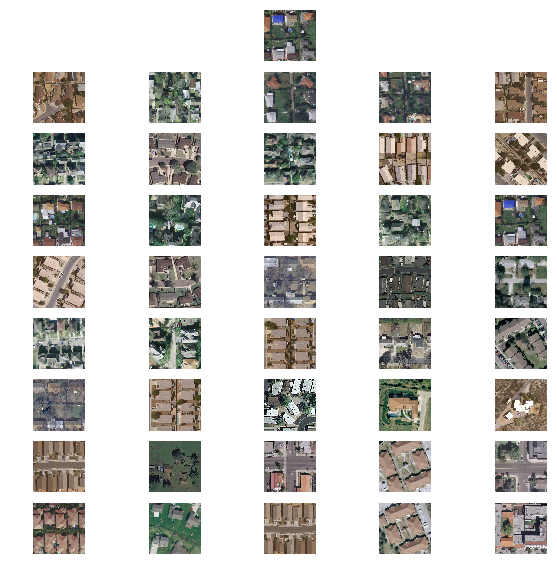

In [18]:
# for _ in range(3): # 搜三张试试吧
# k = random.randint(0, len(Gallery_dataset))  # 420张图中随机选一张测试
k = 250
plt.subplots(figsize=(10, 10))
print("target label:",Gallery_dataset[k][1])
plt.subplot(9,5,3)
tensor2image(Gallery_dataset[k][0])
plt.axis('off')


pre = query_feature(Gallery_dataset[k][0])
pre = pca.transform(pre) # 对单个512=>32
res = search_similar(pre, new_features)
sim = np.argsort(res)[-40:]  # 取top5张特征向量融合



# ## 查询拓展  生成new_query
# new_query = 0
# for index in sim:
#     new_query += features[index]
# new_query = new_query / 5
# res = search_similar(new_query, features)
# sim = np.argsort(res)[-10:]  # 取最相似的20张  40

preLabelList = []
i = 6
print('found label : ',end='')
for index in range(len(sim)):
    re = sim[len(sim)-1-index]
    plt.subplot(9, 5, i)      
    tensor2image(Gallery_dataset[re][0])
    print('%s ' % (Gallery_dataset[re][1]),end='')
    preLabelList.append(Gallery_dataset[re][1])
    i += 1
    plt.axis('off')
print(compute_AP_and_P(preLabelList, Gallery_dataset[k][1]))
plt.show()

In [19]:
# mAP
import time
sum_AP = 0.0
P_three_sum = [0,0,0]
time_start = time.time()
for k in range(len(Gallery_dataset)): # 对所有图片进行搜索 420  21*20

#     k = random.randint(0, len(Gallery_dataset))  # 2400张图中随机选一张测试
    pre = query_feature(Gallery_dataset[k][0])
    pre = pca.transform(pre) # 对单个512=>32
    res = search_similar(pre, new_features)
#     sim = np.argsort(res)[-40:]  # 返回前40张
    sim = np.argsort(res)[-10:]  # 5张融合
    
    ## 查询拓展  生成new_query
    new_query = 0
    for index in sim:
        new_query += features[index]
    new_query = new_query / 5
    res = search_similar(new_query, features)
    sim = np.argsort(res)[:]  # 取最相似的all

    preLabelList = []
#     i = 6
#     print('found label : ',end='')
    for index in range(len(sim)):
        re = sim[len(sim)-1-index]
#         plt.subplot(9, 5, i)      
#         tensor2image(Gallery_dataset[re][0])
#         print('%s ' % (Gallery_dataset[re][1]),end='')
        preLabelList.append(Gallery_dataset[re][1])
#         i += 1
#         plt.axis('off')
#     plt.show()
    AP, P_three = compute_AP_and_P(preLabelList, Gallery_dataset[k][1])
    if k % 50 == 0:
        print('k: ', k ,'label: ', Gallery_dataset[k][1], 'AP: ', AP)
    sum_AP += AP
    for i in range(3):
        P_three_sum[i] += P_three[i]
time_end = time.time()
print('Time cost = %fs' % (time_end - time_start))
mAP = sum_AP / len(Gallery_dataset)
P_three_mean = [0,0,0]
for i in range(3):
    P_three_mean[i] = P_three_sum[i]/len(Gallery_dataset)

k:  0 label:  0 AP:  1.0
k:  50 label:  2 AP:  0.9611829285489941
k:  100 label:  5 AP:  1.0
k:  150 label:  7 AP:  1.0
k:  200 label:  10 AP:  1.0
k:  250 label:  12 AP:  0.77497170555772
k:  300 label:  15 AP:  1.0
k:  350 label:  17 AP:  1.0
k:  400 label:  20 AP:  1.0
Time cost = 681.183942s


In [20]:
mAP

0.9130283399800798

In [21]:
P_three_mean

[0.942380952380953, 0.9292857142857139, 0.8448809523809484]

## RMAC d=64

k:  0 label:  0 AP:  1.0
k:  50 label:  2 AP:  0.8580323672428934
k:  100 label:  5 AP:  1.0
k:  150 label:  7 AP:  1.0
k:  200 label:  10 AP:  1.0
k:  250 label:  12 AP:  0.7097012085585493
k:  300 label:  15 AP:  1.0
k:  350 label:  17 AP:  1.0
k:  400 label:  20 AP:  1.0
Time cost = 673.988852s


In [19]:
mAP

0.8767985992932119

In [20]:
P_three_mean

[0.938571428571429, 0.9152380952380946, 0.7995238095238083]

## avg  d=32 

In [21]:
mAP

0.8533146707983308

In [22]:
P_three_mean

[0.9314285714285722, 0.8928571428571431, 0.7728571428571416]